In [208]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)
import seaborn as sns
import json
from dateutil import parser, tz
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/New_York')

import re
fname = 'search-terms.txt'
f = open(fname,'r')
p = '|(\s|#|@)'.join([line.rstrip() for line in f.readlines()])
f.close()


In [191]:
rdd = sc.textFile('data/*.gz').repartition(10).cache()

In [106]:
def make_json(tweet):
    ''' Get stringified JSOn from Kafka, attempt to convert to JSON '''
    try:
        return json.loads(tweet.decode('utf-8'))
    except:
        return "error"+str(tweet.decode('utf-8'))

def filter_tweets(item,pattern):
    ''' Filters out the tweets we do not want.  Filters include:
            * No retweets 
            * No geolocation or location field (do we really care about this?)
            * English language only
            * No tweets with links
                - We need to check both entities and media fields for this (is that true?)
    '''
    return (('delete' not in item.keys()) and
            ('retweeted_status' not in item.keys())                           and 
            (item['lang']=='en')                       and
            (len(item['entities']['urls'])==0)                   and
            ('media' not in item['entities'].keys()) and
            (re.search(pattern,item['text'],re.I) is not None)
           )

def get_relevant_fields(item):
    ''' Reduce the full set of metadata down to only those we care about, including:
            * timestamp
            * username
            * text of tweet 
            * hashtags
            * geotag coordinates (if any)
            * location (user-defined in profile, not necessarily current location)
    '''
    return (item['id'], 
            {"timestamp":  item['created_at'],
             "username":    item['user']['screen_name'],
             "text":        item['text'],
             "hashtags":    [el['text'] for el in item['entities']['hashtags']],
             "geotag":    item['geo'],
             "user_loc":    item['user']['location']
            }
           )

In [119]:
#print "Total:",rdd.count()
#print "Non-deletes:",rdd.map(make_json).count()
#print "Passed filter:",rdd.map(make_json).filter(filter_tweets).count()


In [192]:
rddj = rdd.map(make_json).cache()

In [ ]:
#print "Passed filter:",rddj.filter(filter_tweets).count()

In [193]:
a = rddj.filter(lambda x: filter_tweets(x,p)).map(get_relevant_fields)

In [194]:
postf = a.collect()


In [196]:
len(postf)

14919

In [197]:
tweet_ids, tweets = zip(*postf)

In [198]:
dts = np.empty(len(tweets),dtype=object)
for i,x in enumerate(tweets):
    dt = parser.parse(x['timestamp'])
    utc = dt.replace(tzinfo=from_zone)
    dt2 = utc.astimezone(to_zone)
    dts[i] = dt2


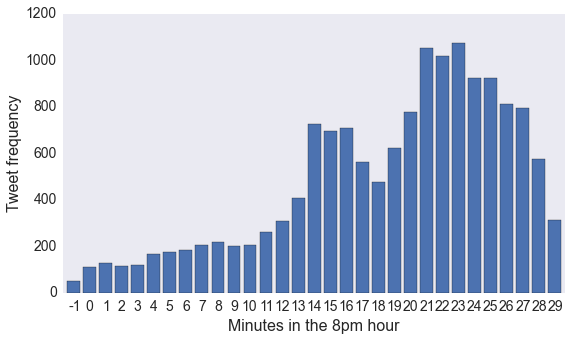

In [255]:
df = pd.DataFrame(dts,columns=['tstamp'])
counts = df.tstamp.groupby(df.tstamp.dt.minute).count()
np.put( counts.index.values, np.where(counts.index==59)[0],-1)
ax = counts.sort_index().plot(kind='bar',
                              figsize=(9,5),
                              width=.8,
                              fontsize=14,
                              rot=0)
ax.set_ylabel("Tweet frequency",fontsize=16)
ax.set_xlabel("Minutes in the 8pm hour",fontsize=16)